In [1]:
for (package in c(
    'dplyr',
    'ggplot2',
    'lubridate',
    'tidyr',
    'fasttime',
    'pROC',
    'caret')) {
    if (!require(package, character.only=T, quietly=T)) {
        install.packages(package, repos="http://cran.us.r-project.org")
        library(package, character.only=T)
    }
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:SparkR’:

    arrange, between, collect, count, cume_dist, dense_rank, desc,
    distinct, explain, filter, first, group_by, intersect, lag, last,
    lead, mutate, n, n_distinct, ntile, percent_rank, rename,
    row_number, sample_frac, select, sql, summarize, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following objects are masked from ‘package:SparkR’:

    hour, minute, month, quarter, second, year

The following object is masked from ‘package:base’:

    date

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:SparkR’:

    cov, var

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘lattice’

The following object is masked from ‘

# Load source files

In [2]:

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "0592036926cf47bf87e889ec75d0d38b",'},"password": ',
                    "W-ucS.1Ge_fr.0b(",',"name": ', "member_e28904fb9993787d907536191c825c593c36c601",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}




read in file cc_log.csv, cc_log_10pct.csv, cc_log_1pct.csv to use the desired sampling. sampled on card level

In [3]:
cc_log <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a(
    "201710kbankibm", "cc_log_1pct.csv"), stringsAsFactors = FALSE)


Loading required package: httr

Attaching package: ‘httr’

The following object is masked from ‘package:caret’:

    progress

Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:tidyr’:

    complete

The following object is masked from ‘package:SparkR’:

    base64



In [4]:
str(cc_log)

# disabled, as date processing is slow.
#cc_log$ts <- as.POSIXct(strptime(paste(substr(cc_log$txn_dt,1,10), cc_log$txn_tm), "%Y-%m-%d %H:%M:%S"))
#cc_log %>% select(-txn_dt, -txn_tm) -> cc_log

cc_log$card_acpt_cty <- as.factor(cc_log$card_acpt_cty)
cc_log$card_type <- as.factor(cc_log$card_type)
cc_log$card_no <- as.character(cc_log$card_no)
str(cc_log)

'data.frame':	53519 obs. of  7 variables:
 $ card_no      : num  4.41e+15 4.41e+15 4.41e+15 4.41e+15 4.41e+15 ...
 $ txn_dt       : chr  "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" ...
 $ txn_tm       : chr  "20:52:34" "15:27:46" "14:42:04" "07:39:30" ...
 $ bill_amt     : int  3760 2820 1940 1460 760 9000 140 4900 1000 1000 ...
 $ card_acpt_cty: chr  "TH" "TH" "TH" "TH" ...
 $ mrch_tp_cd   : int  7011 8062 5541 5541 5699 6300 5735 5812 5960 5541 ...
 $ card_type    : chr  "visa" "visa" "visa" "visa" ...
'data.frame':	53519 obs. of  7 variables:
 $ card_no      : chr  "4410123456087543" "4410123456064643" "4410123456074843" "4410123456094143" ...
 $ txn_dt       : chr  "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" ...
 $ txn_tm       : chr  "20:52:34" "15:27:46" "14:42:04" "07:39:30" ...
 $ bill_amt     : int  3760 2820 19

In [5]:

Final_categories <- read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a(
    "201710kbankibm", "Final_categories.csv"))#"final_cat_acronym.csv"))
head(Final_categories)
str(Final_categories)

left_join(cc_log %>% rename(MCC=mrch_tp_cd), Final_categories, by = "MCC") -> cc_log_mcc

head(cc_log_mcc)
str(cc_log_mcc)
summary(cc_log_mcc)


Categories,MCC
Airlines,3000
Airlines,3001
Airlines,3002
Airlines,3003
Airlines,3004
Airlines,3005


'data.frame':	1185 obs. of  2 variables:
 $ Categories: Factor w/ 19 levels "Airlines","Amusement and Entertainment",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ MCC       : int  3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 ...


card_no,txn_dt,txn_tm,bill_amt,card_acpt_cty,MCC,card_type,Categories
4410123456087543,2017-03-21T00:00:00.000+07:00,20:52:34,3760,TH,7011,visa,Hotels and Motels
4410123456064643,2017-03-21T00:00:00.000+07:00,15:27:46,2820,TH,8062,visa,Professional Services and Membership Organizations
4410123456074843,2017-03-21T00:00:00.000+07:00,14:42:04,1940,TH,5541,visa,Automobiles and Vehicles
4410123456094143,2017-03-21T00:00:00.000+07:00,07:39:30,1460,TH,5541,visa,Automobiles and Vehicles
4410123456088843,2017-03-21T00:00:00.000+07:00,13:06:23,760,TH,5699,visa,Clothing Stores
4410123456096543,2017-03-21T00:00:00.000+07:00,09:17:36,9000,TH,6300,visa,Service Providers


'data.frame':	53519 obs. of  8 variables:
 $ card_no      : chr  "4410123456087543" "4410123456064643" "4410123456074843" "4410123456094143" ...
 $ txn_dt       : chr  "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" ...
 $ txn_tm       : chr  "20:52:34" "15:27:46" "14:42:04" "07:39:30" ...
 $ bill_amt     : int  3760 2820 1940 1460 760 9000 140 4900 1000 1000 ...
 $ card_acpt_cty: Factor w/ 64 levels "","AE","AT","AU",..: 60 60 60 60 60 60 27 60 60 60 ...
 $ MCC          : int  7011 8062 5541 5541 5699 6300 5735 5812 5960 5541 ...
 $ card_type    : Factor w/ 2 levels "master","visa": 2 2 2 2 2 2 1 2 1 2 ...
 $ Categories   : Factor w/ 19 levels "Airlines","Amusement and Entertainment",..: 9 13 3 3 6 16 11 11 10 3 ...


   card_no             txn_dt             txn_tm             bill_amt      
 Length:53519       Length:53519       Length:53519       Min.   :      0  
 Class :character   Class :character   Class :character   1st Qu.:    600  
 Mode  :character   Mode  :character   Mode  :character   Median :   1060  
                                                          Mean   :   4402  
                                                          3rd Qu.:   2660  
                                                          Max.   :1293560  
                                                                           
 card_acpt_cty        MCC        card_type                        Categories   
 TH     :47460   Min.   :   0   master: 9628   Retail Stores           :13271  
 LU     : 1452   1st Qu.:5411   visa  :43891   Miscellaneous Stores    :10366  
 GB     : 1226   Median :5541                  Automobiles and Vehicles: 9774  
 IE     :  876   Mean   :5794                  Service Providers       :

In [6]:

cc_info <- read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a(
    "201710kbankibm", "cc_info.csv"))
cc_info$opn_dt <- as.Date(cc_info$opn_dt)
head(cc_info)
str(cc_info)


card_no,card_type,opn_dt,exp_dt,cr_lmt_amt,prev_cr_lmt_amt,main_zip_cd,cr_line_amt,incm_amt,brth_estb_yr
4.410123e+15,visa,1997-10-14,1017,50000,0,73120,50000,21000,1953
4.410123e+15,master,2010-06-29,620,146000,0,43000,146000,72000,1965
4.410123e+15,visa,2014-06-18,619,22000,0,23000,22000,20000,1978
4.410123e+15,visa,2014-11-03,1119,1000000,0,10200,2141000,1800000,1955
4.410123e+15,visa,2014-04-10,419,80000,0,57160,80000,32000,1969
4.410123e+15,visa,2015-12-18,1220,100000,0,10150,100000,66000,1991


'data.frame':	99594 obs. of  10 variables:
 $ card_no        : num  4.41e+15 4.41e+15 4.41e+15 4.41e+15 4.41e+15 ...
 $ card_type      : Factor w/ 2 levels "master","visa": 2 1 2 2 2 2 1 2 2 2 ...
 $ opn_dt         : Date, format: "1997-10-14" "2010-06-29" ...
 $ exp_dt         : int  1017 620 619 1119 419 1220 118 122 522 518 ...
 $ cr_lmt_amt     : int  50000 146000 22000 1000000 80000 100000 65000 48000 327000 30000 ...
 $ prev_cr_lmt_amt: int  0 0 0 0 0 0 52000 30000 273000 0 ...
 $ main_zip_cd    : num  73120 43000 23000 10200 57160 ...
 $ cr_line_amt    : int  50000 146000 22000 2141000 80000 100000 65000 48000 327000 45000 ...
 $ incm_amt       : int  21000 72000 20000 1800000 32000 66000 26000 20000 109000 19000 ...
 $ brth_estb_yr   : Factor w/ 102 levels "1900","1901",..: 38 50 63 40 54 76 71 72 34 51 ...


# Number of cards per month

In [7]:
cc_log_mcc$month <- floor_date(fastPOSIXct(cc_log_mcc$txn_dt), "month")
str(cc_log_mcc)

'data.frame':	53519 obs. of  9 variables:
 $ card_no      : chr  "4410123456087543" "4410123456064643" "4410123456074843" "4410123456094143" ...
 $ txn_dt       : chr  "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" "2017-03-21T00:00:00.000+07:00" ...
 $ txn_tm       : chr  "20:52:34" "15:27:46" "14:42:04" "07:39:30" ...
 $ bill_amt     : int  3760 2820 1940 1460 760 9000 140 4900 1000 1000 ...
 $ card_acpt_cty: Factor w/ 64 levels "","AE","AT","AU",..: 60 60 60 60 60 60 27 60 60 60 ...
 $ MCC          : int  7011 8062 5541 5541 5699 6300 5735 5812 5960 5541 ...
 $ card_type    : Factor w/ 2 levels "master","visa": 2 2 2 2 2 2 1 2 1 2 ...
 $ Categories   : Factor w/ 19 levels "Airlines","Amusement and Entertainment",..: 9 13 3 3 6 16 11 11 10 3 ...
 $ month        : POSIXct, format: "2017-03-01" "2017-03-01" ...


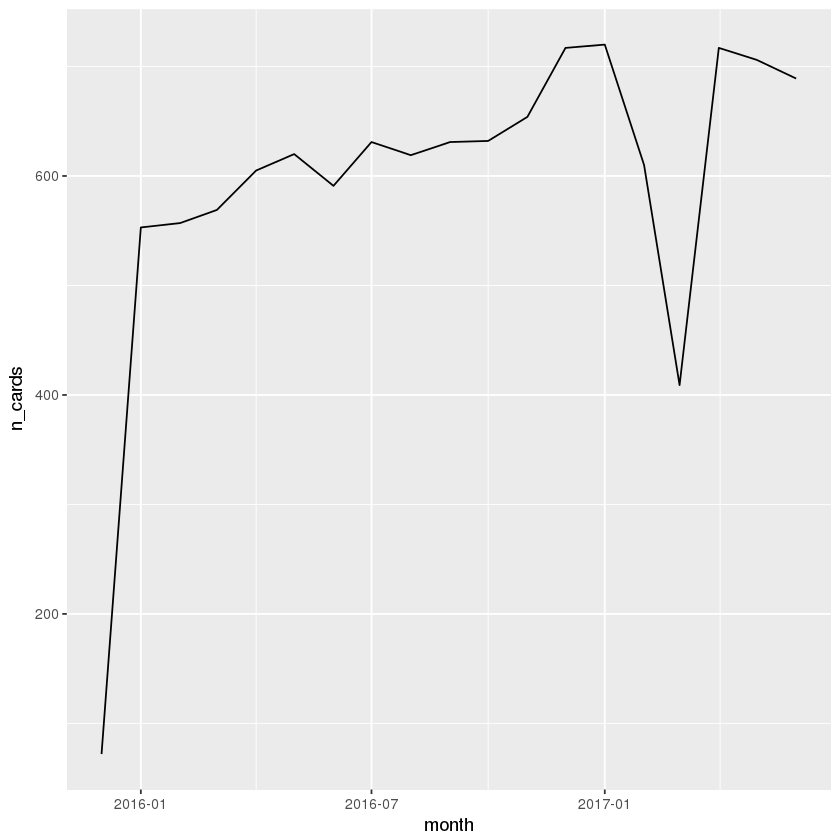

In [8]:

ggplot(data = cc_log_mcc %>% 
       group_by(month, card_no) %>% 
       summarize() %>% 
       group_by(month) %>% 
       summarize(n_cards=n())) + geom_line(aes(month,n_cards))

# Number of transactions per month

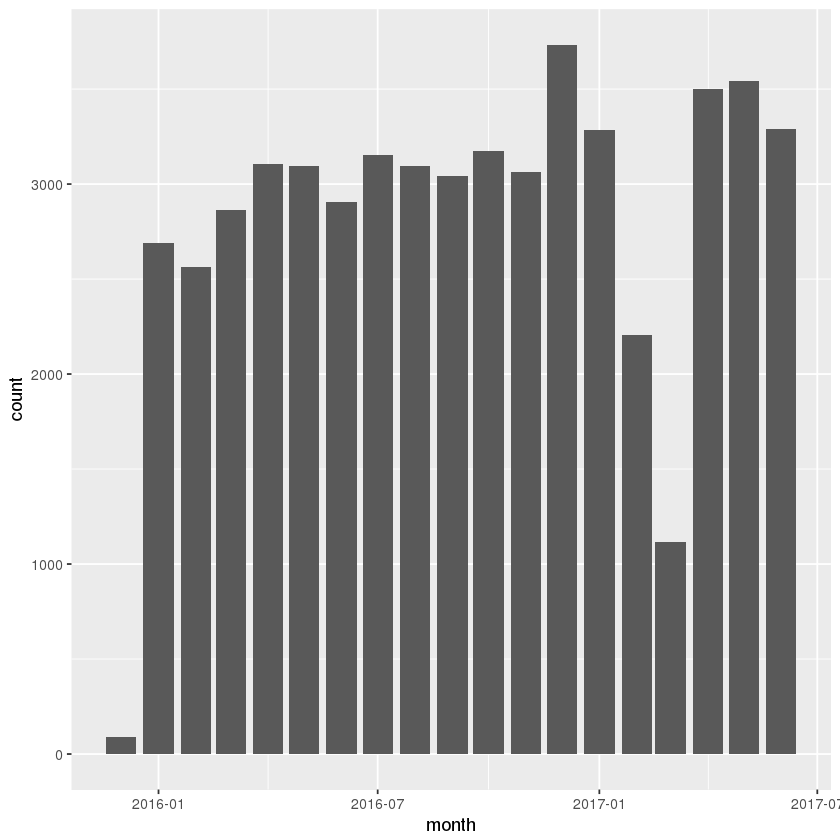

In [9]:
ggplot(data = cc_log_mcc) + geom_bar(aes(month))

# Filter only for categories in scope

In [10]:
cat_inscope = c(
    "Automobiles and Vehicles",
    "Clothing Stores",
    "Service Providers",
    "Transportation",
    "Utilities")

summary(cc_log_mcc$Categories, maxsum = 10)
cc_log_mcc %>% filter(Categories %in% cat_inscope) -> cc_log_mcc
cc_log_mcc$Categories <- factor(cc_log_mcc$Categories)
summary(cc_log_mcc$Categories, maxsum = 10)

Retail Stores 
                                             13271 
                              Miscellaneous Stores 
                                             10366 
                          Automobiles and Vehicles 
                                              9774 
                                 Service Providers 
                                              5966 
                                         Utilities 
                                              2806 
Professional Services and Membership Organizations 
                                              2567 
                                   Clothing Stores 
                                              1897 
                                    Transportation 
                                              1632 
                                           (Other) 
                                              5239 
                                              NA's 
                                                 1

Automobiles and Vehicles          Clothing Stores        Service Providers 
                    9774                     1897                     5966 
          Transportation                Utilities 
                    1632                     2806

In [11]:
bind_rows(
    cc_log_mcc %>%
        mutate(Categories=paste(Categories, "spend", sep = "_")) %>%
        group_by(card_no, month, Categories) %>%
        dplyr::summarize(value = sum(bill_amt)),
    cc_log_mcc %>%
        mutate(Categories=paste(Categories, "freq", sep = "_")) %>%
        group_by(card_no, month, Categories) %>%
        dplyr::summarize(value=n())
) -> cc_monthly
cc_monthly %>% spread(Categories,value) -> cc_monthly

# make sure all combinations of card_no and month are present:
full_join(
    cc_monthly,
    merge(distinct(cc_monthly["card_no"]), distinct(cc_monthly["month"])),
    by = c("card_no", "month")) %>%
    arrange(card_no, month) -> cc_monthly

cc_monthly[is.na(cc_monthly)] <- 0
head(cc_monthly)

card_no,month,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,2015-12-01,0,0,0,0,0,0,0,0,0,0
4410123456000043,2016-01-01,3,3040,0,0,0,0,0,0,0,0
4410123456000043,2016-02-01,3,16460,3,2760,0,0,0,0,0,0
4410123456000043,2016-03-01,0,0,0,0,0,0,0,0,0,0
4410123456000043,2016-04-01,0,0,2,4680,0,0,0,0,0,0
4410123456000043,2016-05-01,1,920,0,0,0,0,0,0,0,0


Targeting month TARGETMONTH, the actual data is:

In [12]:
TARGETMONTH <- as.Date("2016-12-01")
cc_monthly %>% filter(month == TARGETMONTH) %>% arrange(card_no) -> target
cc_monthly %>% filter(month == floor_date(TARGETMONTH - 28,"month")) %>% arrange(card_no) -> target_lastmonth
names(target_lastmonth)[names(target_lastmonth) != "card_no"] <- 
    paste(names(target_lastmonth)[names(target_lastmonth) != "card_no"], "lastmonth", sep = "_")
target <- left_join(target,target_lastmonth, by = "card_no")
head(target)
str(target)

card_no,month,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,...,Automobiles and Vehicles_freq_lastmonth,Automobiles and Vehicles_spend_lastmonth,Clothing Stores_freq_lastmonth,Clothing Stores_spend_lastmonth,Service Providers_freq_lastmonth,Service Providers_spend_lastmonth,Transportation_freq_lastmonth,Transportation_spend_lastmonth,Utilities_freq_lastmonth,Utilities_spend_lastmonth
4410123456000043,2016-12-01,1,1000,1,500,1,50000,0,0,...,2,2000,1,1200,0,0,0,0,0,0
4410123456000143,2016-12-01,0,0,0,0,4,49700,0,0,...,0,0,0,0,2,15500,0,0,0,0
4410123456000243,2016-12-01,2,2380,0,0,0,0,0,0,...,0,0,0,0,1,11240,0,0,0,0
4410123456000343,2016-12-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4410123456000443,2016-12-01,2,1760,3,4800,0,0,0,0,...,1,1200,1,580,0,0,0,0,0,0
4410123456000543,2016-12-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	933 obs. of  23 variables:
 $ card_no                                 : chr  "4410123456000043" "4410123456000143" "4410123456000243" "4410123456000343" ...
 $ month                                   : POSIXct, format: "2016-12-01" "2016-12-01" ...
 $ Automobiles and Vehicles_freq           : num  1 0 2 0 2 0 0 3 0 0 ...
 $ Automobiles and Vehicles_spend          : num  1000 0 2380 0 1760 0 0 3940 0 0 ...
 $ Clothing Stores_freq                    : num  1 0 0 0 3 0 0 0 0 0 ...
 $ Clothing Stores_spend                   : num  500 0 0 0 4800 0 0 0 0 0 ...
 $ Service Providers_freq                  : num  1 4 0 0 0 0 0 0 0 1 ...
 $ Service Providers_spend                 : num  50000 49700 0 0 0 0 0 0 0 420 ...
 $ Transportation_freq                     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Transportation_spend                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Utilities_freq                          : num  0 0 0 0 1 0 0 1 0 0 ...
 $ Utilities_spe

The following naive models work only from data until 2016-11. (of course, they could include other predictors and higher timely resolution as well, for the same period.)

In [13]:
cc_monthly %>% filter(month < TARGETMONTH) -> cc_tspredictors
summary(cc_tspredictors$month)

                 Min.               1st Qu.                Median 
"2015-12-01 00:00:00" "2016-02-22 18:00:00" "2016-05-16 12:00:00" 
                 Mean               3rd Qu.                  Max. 
"2016-05-16 20:20:00" "2016-08-08 18:00:00" "2016-11-01 00:00:00" 

Naive model 1: last known month.

In [14]:
cc_tspredictors %>%
    filter(month == max(cc_tspredictors$month)) %>%
    select(-month) %>%
    arrange(card_no) -> estimate.n1_lastmonth
head(estimate.n1_lastmonth)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,2,2000,1,1200,0,0,0,0,0,0
4410123456000143,0,0,0,0,2,15500,0,0,0,0
4410123456000243,0,0,0,0,1,11240,0,0,0,0
4410123456000343,0,0,0,0,0,0,0,0,0,0
4410123456000443,1,1200,1,580,0,0,0,0,0,0
4410123456000543,0,0,0,0,0,0,0,0,0,0


Naive model 1B: last known month, avgd across customers.

In [15]:
merge(unique(cc_tspredictors["card_no"]),
    cc_tspredictors %>%
    filter(month == max(cc_tspredictors$month)) %>%
    select(-month) %>%
    dplyr::summarize(
        `Automobiles and Vehicles_freq.mean`  = mean(`Automobiles and Vehicles_freq` ),
        `Automobiles and Vehicles_spend.mean` = mean(`Automobiles and Vehicles_spend`),
        `Clothing Stores_freq.mean`           = mean(`Clothing Stores_freq`          ),
        `Clothing Stores_spend.mean`          = mean(`Clothing Stores_spend`         ),
        `Service Providers_freq.mean`         = mean(`Service Providers_freq`        ),
        `Service Providers_spend.mean`        = mean(`Service Providers_spend`       ),
        `Transportation_freq.mean`            = mean(`Transportation_freq`           ),
        `Transportation_spend.mean`           = mean(`Transportation_spend`          ),
        `Utilities_freq.mean`                 = mean(`Utilities_freq`                ),
        `Utilities_spend.mean`                = mean(`Utilities_spend`               )) %>%
    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles and Vehicles_freq.mean` ,
        `Automobiles and Vehicles_spend` = `Automobiles and Vehicles_spend.mean`,
        `Clothing Stores_freq`           = `Clothing Stores_freq.mean`          ,
        `Clothing Stores_spend`          = `Clothing Stores_spend.mean`         ,
        `Service Providers_freq`         = `Service Providers_freq.mean`        ,
        `Service Providers_spend`        = `Service Providers_spend.mean`       ,
        `Transportation_freq`            = `Transportation_freq.mean`           ,
        `Transportation_spend`           = `Transportation_spend.mean`          ,
        `Utilities_freq`                 = `Utilities_freq.mean`                ,
        `Utilities_spend`                = `Utilities_spend.mean`               
    )) -> estimate.n1b_lastmonth_avgcust
head(estimate.n1b_lastmonth_avgcust)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894
4410123456000143,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894
4410123456000243,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894
4410123456000343,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894
4410123456000443,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894
4410123456000543,0.6227224,1423.987,0.1318328,447.8457,0.4062165,7747.438,0.09003215,197.5563,0.192926,690.2894


Naive model 2: lont-term avg.

In [16]:
cc_tspredictors %>%
    group_by(card_no) %>%
    summarize(
        `Automobiles and Vehicles_freq_mean` = mean(`Automobiles and Vehicles_freq`),
        `Automobiles and Vehicles_spend_mean` = mean(`Automobiles and Vehicles_spend`),
        `Clothing Stores_freq_mean` = mean(`Clothing Stores_freq`),
        `Clothing Stores_spend_mean` = mean(`Clothing Stores_spend`),
        `Service Providers_freq_mean` = mean(`Service Providers_freq`),
        `Service Providers_spend_mean` = mean(`Service Providers_spend`),
        Transportation_freq_mean = mean(Transportation_freq),
        Transportation_spend_mean = mean(Transportation_spend),
        Utilities_freq_mean = mean(Utilities_freq),
        Utilities_spend_mean = mean(Utilities_spend)) -> estimate.n2_longtermavg
names(estimate.n2_longtermavg) = sapply(names(estimate.n2_longtermavg),function(x) gsub("_mean$","",x))
head(estimate.n2_longtermavg)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,0.7500000,1868.3333,0.50000000,720.00000,0.000000,0.000,0,0,0.00000000,0.00000
4410123456000143,0.0000000,0.0000,0.00000000,0.00000,1.833333,8100.000,0,0,0.00000000,0.00000
4410123456000243,0.3333333,328.3333,0.00000000,0.00000,0.250000,3228.333,0,0,0.00000000,0.00000
4410123456000343,0.0000000,0.0000,0.08333333,58.33333,0.000000,0.000,0,0,0.08333333,31.66667
4410123456000443,1.0000000,1016.6667,0.58333333,525.00000,0.000000,0.000,0,0,0.50000000,1035.00000
4410123456000543,0.0000000,0.0000,0.00000000,0.00000,0.000000,0.000,0,0,0.00000000,0.00000


In [17]:
merge(unique(cc_tspredictors["card_no"]),
    cc_tspredictors %>%
    summarize(
        `Automobiles and Vehicles_freq_mean` = mean(`Automobiles and Vehicles_freq`),
        `Automobiles and Vehicles_spend_mean` = mean(`Automobiles and Vehicles_spend`),
        `Clothing Stores_freq_mean` = mean(`Clothing Stores_freq`),
        `Clothing Stores_spend_mean` = mean(`Clothing Stores_spend`),
        `Service Providers_freq_mean` = mean(`Service Providers_freq`),
        `Service Providers_spend_mean` = mean(`Service Providers_spend`),
        Transportation_freq_mean = mean(Transportation_freq),
        Transportation_spend_mean = mean(Transportation_spend),
        Utilities_freq_mean = mean(Utilities_freq),
        Utilities_spend_mean = mean(Utilities_spend))) -> estimate.n2b_longtermavg_avgcust
names(estimate.n2b_longtermavg_avgcust) = sapply(names(estimate.n2b_longtermavg_avgcust),function(x) gsub("_mean$","",x))
head(estimate.n2b_longtermavg_avgcust)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204
4410123456000143,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204
4410123456000243,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204
4410123456000343,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204
4410123456000443,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204
4410123456000543,0.5279564,1057.165,0.1068239,399.6838,0.3407467,3856.522,0.09199714,362.249,0.1527331,496.204


Naive model 3: two-point extrapolation

In [18]:
cc_tspredictors %>%
    filter(month == max(cc_tspredictors$month)) -> n3_lastmonth

secondlastmonth <- max(cc_tspredictors[cc_tspredictors$month < max(cc_tspredictors$month),]$month)

cc_tspredictors %>%
    filter(month == secondlastmonth) -> n3_secondlastmonth
names(n3_secondlastmonth)
inner_join(n3_secondlastmonth, n3_lastmonth, by = "card_no") %>%
    transmute(
        card_no = card_no,
        `Automobiles and Vehicles_freq` = 2 * `Automobiles and Vehicles_freq.y` - `Automobiles and Vehicles_freq.x`,
        `Automobiles and Vehicles_spend` = 2 * `Automobiles and Vehicles_spend.y` - `Automobiles and Vehicles_spend.x`,
        `Clothing Stores_freq` = 2 * `Clothing Stores_freq.y` - `Clothing Stores_freq.x`,
        `Clothing Stores_spend` = 2 * `Clothing Stores_spend.y` - `Clothing Stores_spend.x`,
        `Service Providers_freq` = 2 * `Service Providers_freq.y` - `Service Providers_freq.x`,
        `Service Providers_spend` = 2 * `Service Providers_spend.y` - `Service Providers_spend.x`,
        `Transportation_freq` = 2 * `Transportation_freq.y` - `Transportation_freq.x`,
        `Transportation_spend` = 2 * `Transportation_spend.y` - `Transportation_spend.x`,
        `Utilities_freq` = 2 * `Utilities_freq.y` - `Utilities_freq.x`,
        `Utilities_spend` = 2 * `Utilities_spend.y` - `Utilities_spend.x`) -> estimate.n3_twopoint
head(estimate.n3_twopoint)

[1] "card_no"                        "month"                         
 [3] "Automobiles and Vehicles_freq"  "Automobiles and Vehicles_spend"
 [5] "Clothing Stores_freq"           "Clothing Stores_spend"         
 [7] "Service Providers_freq"         "Service Providers_spend"       
 [9] "Transportation_freq"            "Transportation_spend"          
[11] "Utilities_freq"                 "Utilities_spend"

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,4,4000,2,2400,0,0,0,0,0,0
4410123456000143,0,0,0,0,3,24000,0,0,0,0
4410123456000243,-3,-3440,0,0,2,22480,0,0,0,0
4410123456000343,0,0,0,0,0,0,0,0,0,0
4410123456000443,-2,-2500,1,500,0,0,0,0,0,0
4410123456000543,0,0,0,0,0,0,0,0,0,0


naive 4: last year same month

In [19]:
cc_tspredictors %>%
    filter(month == floor_date(TARGETMONTH - 365,"month")) %>%
    select(-month) -> estimate.n4_lastyear
head(estimate.n4_lastyear)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,0,0,0,0,0,0,0,0,0,0
4410123456000143,0,0,0,0,0,0,0,0,0,0
4410123456000243,0,0,0,0,0,0,0,0,0,0
4410123456000343,0,0,0,0,0,0,0,0,0,0
4410123456000443,0,0,0,0,0,0,0,0,0,0
4410123456000543,0,0,0,0,0,0,0,0,0,0


naive 5: all zeros

In [20]:
cc_tspredictors %>%
    filter(month == max(cc_tspredictors$month)) %>%
    select(-month) -> estimate.n5_zeros
estimate.n5_zeros[ , sapply(estimate.n5_zeros, is.numeric)] <- 0
head(estimate.n5_zeros)

card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,0,0,0,0,0,0,0,0,0,0
4410123456000143,0,0,0,0,0,0,0,0,0,0
4410123456000243,0,0,0,0,0,0,0,0,0,0
4410123456000343,0,0,0,0,0,0,0,0,0,0
4410123456000443,0,0,0,0,0,0,0,0,0,0
4410123456000543,0,0,0,0,0,0,0,0,0,0


In [21]:

two_point_extrapolation_chirateep <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "two_point_extrapolation_chirateep_1pct.csv"))
head(two_point_extrapolation_chirateep)
two_point_extrapolation_chirateep$card_no <- as.character(two_point_extrapolation_chirateep$card_no)

two_point_extrapolation_chirateep %>%
    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.sum`,
        `Clothing Stores_freq`           = `Clothing.Stores.freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.sum`         ,
        `Service Providers_freq`         = `Service.Providers.freq`        ,
        `Service Providers_spend`        = `Service.Providers.sum`       ,
        `Transportation_freq`            = `Transportation.freq`           ,
        `Transportation_spend`           = `Transportation.sum`          ,
        `Utilities_freq`                 = `Utilities.freq`                ,
        `Utilities_spend`                = `Utilities.sum`               ) -> two_point_extrapolation_chirateep



card_no,Automobiles.and.Vehicles.freq,Clothing.Stores.freq,Service.Providers.freq,Transportation.freq,Utilities.freq,Automobiles.and.Vehicles.sum,Clothing.Stores.sum,Service.Providers.sum,Transportation.sum,Utilities.sum
4.410123e+15,0,0,0,0,0,0,0,0,0,0
4.410123e+15,0,0,3,0,0,0,0,24000,0,0
4.410123e+15,0,0,0,0,0,0,0,0,0,0
4.410123e+15,0,0,0,0,0,0,0,0,0,0
4.410123e+15,0,1,0,0,0,0,500,0,0,0
4.410123e+15,0,0,0,0,0,0,0,0,0,0


In [22]:

naive1_11_2016 <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "naive1_11_2016_1pct.csv"))
head(naive1_11_2016)
naive1_11_2016$card_no <- as.character(naive1_11_2016$card_no)

naive1_11_2016 %>%
    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.frequency` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.AMOUNT`,
        `Clothing Stores_freq`           = `Clothing.Stores.frequency`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.AMOUNT`         ,
        `Service Providers_freq`         = `Service.Providers.frequency`        ,
        `Service Providers_spend`        = `Service.Providers.AMOUNT`       ,
        `Transportation_freq`            = `Transportation.frequency`           ,
        `Transportation_spend`           = `Transportation.AMOUNT`          ,
        `Utilities_freq`                 = `Utilities.frequency`                ,
        `Utilities_spend`                = `Utilities.AMOUNT`               ) -> naive1_11_2016




card_no,Automobiles.and.Vehicles.AMOUNT,Automobiles.and.Vehicles.frequency,Clothing.Stores.AMOUNT,Clothing.Stores.frequency,Service.Providers.AMOUNT,Service.Providers.frequency,Transportation.AMOUNT,Transportation.frequency,Utilities.AMOUNT,Utilities.frequency
4.410123e+15,2000,2,1200,1,0,0,0,0,0,0
4.410123e+15,0,0,0,0,22500,3,0,0,0,0
4.410123e+15,0,0,0,0,11240,1,0,0,0,0
4.410123e+15,1200,1,580,1,0,0,0,0,0,0
4.410123e+15,1000,1,400,1,0,0,0,0,1280,1
4.410123e+15,0,0,0,0,840,2,0,0,0,0


In [23]:
satha.mindless.result <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "satha-mindless-result_1pct.csv"))
head(satha.mindless.result)
satha.mindless.result$card_no <- as.character(satha.mindless.result$card_no)

satha.mindless.result %>%    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.sum`,
        `Clothing Stores_freq`           = `Clothing.Stores.freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.sum`         ,
        `Service Providers_freq`         = `Service.Providers.freq`        ,
        `Service Providers_spend`        = `Service.Providers.sum`       ,
        `Transportation_freq`            = `Transportation.freq`           ,
        `Transportation_spend`           = `Transportation.sum`          ,
        `Utilities_freq`                 = `Utilities.freq`                ,
        `Utilities_spend`                = `Utilities.sum`               ) -> satha.mindless.result




Automobiles.and.Vehicles.freq,Automobiles.and.Vehicles.sum,Clothing.Stores.freq,Clothing.Stores.sum,Service.Providers.freq,Service.Providers.sum,Transportation.freq,Transportation.sum,Utilities.freq,Utilities.sum,card_no
2.037701,2543.8505,0.621735,876.4238,0.197726,2657.540,0.064377,260.1621,0.225263,749.03762,4.410123e+15
0.154019,360.4450,0.012391,182.9766,1.454939,8133.866,0.031884,120.5961,0.035134,86.93931,4.410123e+15
0.154019,564.1899,0.039206,192.4805,0.821728,5126.966,0.049448,165.3375,0.052113,228.31349,4.410123e+15
0.200029,360.4450,0.055624,211.6969,0.221264,2057.937,0.036910,175.1407,0.072024,518.31157,4.410123e+15
1.204846,1951.1342,0.493079,696.9131,0.210856,8463.420,0.067056,523.0819,0.199738,690.60079,4.410123e+15
0.069590,438.3162,0.016847,199.4644,0.089784,3033.342,0.032510,141.2788,0.033360,190.64665,4.410123e+15


In [24]:
satha.hmc.result <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "satha-hmc-result_1pct.csv"))
head(satha.hmc.result)
satha.hmc.result$card_no <- as.character(satha.hmc.result$card_no)

satha.hmc.result %>%    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.sum`,
        `Clothing Stores_freq`           = `Clothing.Stores.freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.sum`         ,
        `Service Providers_freq`         = `Service.Providers.freq`        ,
        `Service Providers_spend`        = `Service.Providers.sum`       ,
        `Transportation_freq`            = `Transportation.freq`           ,
        `Transportation_spend`           = `Transportation.sum`          ,
        `Utilities_freq`                 = `Utilities.freq`                ,
        `Utilities_spend`                = `Utilities.sum`               ) -> satha.hmc.result




Automobiles.and.Vehicles.freq,Automobiles.and.Vehicles.sum,Clothing.Stores.freq,Clothing.Stores.sum,Service.Providers.freq,Service.Providers.sum,Transportation.freq,Transportation.sum,Utilities.freq,Utilities.sum,card_no
1.2,1040,0.7,1366,0.6,30000,0.2,0,0.3,2042,4.410123e+15
0.0,0,0.0,0,2.8,8990,0.0,0,0.0,0,4.410123e+15
1.0,1244,0.2,328,0.6,13760,0.0,0,0.6,236,4.410123e+15
0.0,414,0.1,0,0.1,0,0.0,0,0.1,0,4.410123e+15
1.6,1408,2.4,4320,0.0,0,0.0,0,0.7,884,4.410123e+15
0.0,1010,0.0,0,0.0,0,0.0,0,0.0,0,4.410123e+15


In [25]:
noppawee_naive5 <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "noppawee_naive5_1pct.csv"))
head(noppawee_naive5)
noppawee_naive5$card_no <- as.character(noppawee_naive5$card_no)
noppawee_naive5 %>%
    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.Amount`,
        `Clothing Stores_freq`           = `Clothing.Stores.freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.Amount`         ,
        `Service Providers_freq`         = `Service.Providers.freq`        ,
        `Service Providers_spend`        = `Service.Providers.Amount`       ,
        `Transportation_freq`            = `Transportation.freq`           ,
        `Transportation_spend`           = `Transportation.Amount`          ,
        `Utilities_freq`                 = `Utilities.freq`                ,
        `Utilities_spend`                = `Utilities.Amount`               ) -> noppawee_naive5



card_no,Automobiles.and.Vehicles.Amount,Automobiles.and.Vehicles.freq,Clothing.Stores.Amount,Clothing.Stores.freq,Service.Providers.Amount,Service.Providers.freq,Transportation.Amount,Transportation.freq,Utilities.Amount,Utilities.freq
4.410123e+15,1000,0.916667,840,0.583333,40000,0.166667,0,0,0,0.000000
4.410123e+15,0,0.000000,0,0.000000,4950,2.833333,0,0,0,0.000000
4.410123e+15,1200,0.750000,0,0.000000,10370,0.333333,0,0,0,0.000000
4.410123e+15,0,0.000000,700,0.083333,0,0.000000,0,0,380,0.083333
4.410123e+15,960,1.916667,940,1.166667,0,0.000000,0,0,1190,1.000000
4.410123e+15,1000,0.416667,1700,0.083333,0,0.000000,0,0,0,0.000000


In [26]:
chirateep_3 <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "chirateep_3_1pct.csv"))
head(chirateep_3)
chirateep_3$card_no <- as.character(chirateep_3$card_no)
chirateep_3 %>%    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles.freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles.sum`,
        `Clothing Stores_freq`           = `Clothing.Stores.freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores.sum`         ,
        `Service Providers_freq`         = `Service.Providers.freq`        ,
        `Service Providers_spend`        = `Service.Providers.sum`       ,
        `Transportation_freq`            = `Transportation.freq`           ,
        `Transportation_spend`           = `Transportation.sum`          ,
        `Utilities_freq`                 = `Utilities.freq`                ,
        `Utilities_spend`                = `Utilities.sum`               ) -> chirateep_3


card_no,Automobiles.and.Vehicles.freq,Clothing.Stores.freq,Service.Providers.freq,Transportation.freq,Utilities.freq,Automobiles.and.Vehicles.sum,Clothing.Stores.sum,Service.Providers.sum,Transportation.sum,Utilities.sum
4.410123e+15,3,2,0,0,0,3204,1920,0,0,0
4.410123e+15,0,0,2,0,0,0,0,22830,0,0
4.410123e+15,0,0,2,0,0,0,0,19730,0,0
4.410123e+15,0,0,0,0,0,0,0,0,0,0
4.410123e+15,1,1,0,0,0,1550,728,0,0,0
4.410123e+15,0,0,0,0,0,0,0,0,0,0


In [ ]:
Jakkapatr_KNR <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "Jakkapatr_KNR2_1pct.csv"))
head(Jakkapatr_KNR)
Jakkapatr_KNR$card_no <- as.character(Jakkapatr_KNR$card_no)
Jakkapatr_KNR %>%    rename(
        `Automobiles and Vehicles_freq`  = `Automobiles.and.Vehicles_freq` ,
        `Automobiles and Vehicles_spend` = `Automobiles.and.Vehicles_spend`,
        `Clothing Stores_freq`           = `Clothing.Stores_freq`          ,
        `Clothing Stores_spend`          = `Clothing.Stores_spend`         ,
        `Service Providers_freq`         = `Service.Providers_freq`        ,
        `Service Providers_spend`        = `Service.Providers_spend`       ,
        `Transportation_freq`            = `Transportation_freq`           ,
        `Transportation_spend`           = `Transportation_spend`          ,
        `Utilities_freq`                 = `Utilities_freq`                ,
        `Utilities_spend`                = `Utilities_spend`               ) -> Jakkapatr_KNR


In [ ]:
spd_automl_auto <-  read.csv(file = getObjectStorageFileWithCredentials_b3d150584aa142a1975f62c1c8b1699a("201710kbankibm", "spd-automl-auto.csv"))
spd_automl_auto$card_no <- as.character(spd_automl_auto$card_no)
spd_automl_auto %>%    rename(
        `Automobiles and Vehicles_spend` = `X.XR.Automobiles.and.Vehicles_bill_amt_target`) %>%
mutate(
    `Automobiles and Vehicles_freq`  = NA,  
    `Clothing Stores_freq`           = NA,
    `Clothing Stores_spend`          = NA,
    `Service Providers_freq`         = NA,
    `Service Providers_spend`        = NA,
    `Transportation_freq`            = NA,
    `Transportation_spend`           = NA,
    `Utilities_freq`                 = NA,
    `Utilities_spend`                = NA
) -> spd_automl_auto
head(spd_automl_auto)


# Evaluate models

In [42]:
head(target)
head(estimate.n1_lastmonth)

card_no,month,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,...,Automobiles and Vehicles_freq_lastmonth,Automobiles and Vehicles_spend_lastmonth,Clothing Stores_freq_lastmonth,Clothing Stores_spend_lastmonth,Service Providers_freq_lastmonth,Service Providers_spend_lastmonth,Transportation_freq_lastmonth,Transportation_spend_lastmonth,Utilities_freq_lastmonth,Utilities_spend_lastmonth
4410123456000043,2016-12-01,1,1000,1,500,1,50000,0,0,...,2,2000,1,1200,0,0,0,0,0,0
4410123456000143,2016-12-01,0,0,0,0,4,49700,0,0,...,0,0,0,0,2,15500,0,0,0,0
4410123456000243,2016-12-01,2,2380,0,0,0,0,0,0,...,0,0,0,0,1,11240,0,0,0,0
4410123456000343,2016-12-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4410123456000443,2016-12-01,2,1760,3,4800,0,0,0,0,...,1,1200,1,580,0,0,0,0,0,0
4410123456000543,2016-12-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


card_no,Automobiles and Vehicles_freq,Automobiles and Vehicles_spend,Clothing Stores_freq,Clothing Stores_spend,Service Providers_freq,Service Providers_spend,Transportation_freq,Transportation_spend,Utilities_freq,Utilities_spend
4410123456000043,2,2000,1,1200,0,0,0,0,0,0
4410123456000143,0,0,0,0,2,15500,0,0,0,0
4410123456000243,0,0,0,0,1,11240,0,0,0,0
4410123456000343,0,0,0,0,0,0,0,0,0,0
4410123456000443,1,1200,1,580,0,0,0,0,0,0
4410123456000543,0,0,0,0,0,0,0,0,0,0


In [43]:
spd_accuracy <- function(target, estimate, modelname) {
    merge(data.frame(modelname = modelname), left_join(target,estimate, by= "card_no")) -> e
    e[is.na(e)] <- 0

    
    e.auc <- data.frame(
        `Automobiles and Vehicles_freq.auc`  = auc(e$`Automobiles and Vehicles_freq.x`  > 0, e$`Automobiles and Vehicles_freq.y` ),
        `Automobiles and Vehicles_spend.auc` = auc(e$`Automobiles and Vehicles_spend.x`  > 0, e$`Automobiles and Vehicles_spend.y` ),
        `Clothing Stores_freq.auc`           = auc(e$`Clothing Stores_freq.x`  > 0, e$`Clothing Stores_freq.y` ),
        `Clothing Stores_spend.auc`          = auc(e$`Clothing Stores_spend.x`  > 0, e$`Clothing Stores_spend.y` ),
        `Service Providers_freq.auc`         = auc(e$`Service Providers_freq.x`  > 0, e$`Service Providers_freq.y` ),
        `Service Providers_spend.auc`        = auc(e$`Service Providers_spend.x`  > 0, e$`Service Providers_spend.y` ),
        `Transportation_freq.auc`            = auc(e$`Transportation_freq.x`  > 0, e$`Transportation_freq.y` ),
        `Transportation_spend.auc`           = auc(e$`Transportation_spend.x`  > 0, e$`Transportation_spend.y` ),
        `Utilities_freq.auc`                 = auc(e$`Utilities_freq.x`  > 0, e$`Utilities_freq.y` ),
        `Utilities_spend.auc`                = auc(e$`Utilities_spend.x`  > 0, e$`Utilities_spend.y` ), check.names=F)
    
    
    e %>% mutate(
        `Automobiles and Vehicles_freq.e`  = `Automobiles and Vehicles_freq.y` - `Automobiles and Vehicles_freq.x`,
        `Automobiles and Vehicles_spend.e` = `Automobiles and Vehicles_spend.y` - `Automobiles and Vehicles_spend.x`,
        `Clothing Stores_freq.e`           = `Clothing Stores_freq.y` - `Clothing Stores_freq.x`,
        `Clothing Stores_spend.e`          = `Clothing Stores_spend.y` - `Clothing Stores_spend.x`,
        `Service Providers_freq.e`         = `Service Providers_freq.y` - `Service Providers_freq.x`,
        `Service Providers_spend.e`        = `Service Providers_spend.y` - `Service Providers_spend.x`,
        `Transportation_freq.e`            = `Transportation_freq.y` - `Transportation_freq.x`,
        `Transportation_spend.e`           = `Transportation_spend.y` - `Transportation_spend.x`,
        `Utilities_freq.e`                 = `Utilities_freq.y` - `Utilities_freq.x`,
        `Utilities_spend.e`                = `Utilities_spend.y` - `Utilities_spend.x`) %>%
    mutate(
        `Automobiles and Vehicles_freq.se`  = `Automobiles and Vehicles_freq.e` **2,
        `Automobiles and Vehicles_spend.se` = `Automobiles and Vehicles_spend.e`**2,
        `Clothing Stores_freq.se`           = `Clothing Stores_freq.e`          **2,
        `Clothing Stores_spend.se`          = `Clothing Stores_spend.e`         **2,
        `Service Providers_freq.se`         = `Service Providers_freq.e`        **2,
        `Service Providers_spend.se`        = `Service Providers_spend.e`       **2,
        `Transportation_freq.se`            = `Transportation_freq.e`           **2,
        `Transportation_spend.se`           = `Transportation_spend.e`          **2,
        `Utilities_freq.se`                 = `Utilities_freq.e`                **2,
        `Utilities_spend.se`                = `Utilities_spend.e`               **2,
        `Automobiles and Vehicles_freq.ae`  = abs(`Automobiles and Vehicles_freq.e` ),
        `Automobiles and Vehicles_spend.ae` = abs(`Automobiles and Vehicles_spend.e`),
        `Clothing Stores_freq.ae`           = abs(`Clothing Stores_freq.e`          ),
        `Clothing Stores_spend.ae`          = abs(`Clothing Stores_spend.e`         ),
        `Service Providers_freq.ae`         = abs(`Service Providers_freq.e`        ),
        `Service Providers_spend.ae`        = abs(`Service Providers_spend.e`       ),
        `Transportation_freq.ae`            = abs(`Transportation_freq.e`           ),
        `Transportation_spend.ae`           = abs(`Transportation_spend.e`          ),
        `Utilities_freq.ae`                 = abs(`Utilities_freq.e`                ),
        `Utilities_spend.ae`                = abs(`Utilities_spend.e`               )) %>%
    group_by(modelname) %>%
    dplyr::summarize(
        `Automobiles and Vehicles_freq.rmse`  = sqrt(mean(`Automobiles and Vehicles_freq.se` )),
        `Automobiles and Vehicles_spend.rmse` = sqrt(mean(`Automobiles and Vehicles_spend.se`)),
        `Clothing Stores_freq.rmse`           = sqrt(mean(`Clothing Stores_freq.se`          )),
        `Clothing Stores_spend.rmse`          = sqrt(mean(`Clothing Stores_spend.se`         )),
        `Service Providers_freq.rmse`         = sqrt(mean(`Service Providers_freq.se`        )),
        `Service Providers_spend.rmse`        = sqrt(mean(`Service Providers_spend.se`       )),
        `Transportation_freq.rmse`            = sqrt(mean(`Transportation_freq.se`           )),
        `Transportation_spend.rmse`           = sqrt(mean(`Transportation_spend.se`          )),
        `Utilities_freq.rmse`                 = sqrt(mean(`Utilities_freq.se`                )),
        `Utilities_spend.rmse`                = sqrt(mean(`Utilities_spend.se`               )),
        `Automobiles and Vehicles_freq.mae`  = mean(`Automobiles and Vehicles_freq.ae` ),
        `Automobiles and Vehicles_spend.mae` = mean(`Automobiles and Vehicles_spend.ae`),
        `Clothing Stores_freq.mae`           = mean(`Clothing Stores_freq.ae`          ),
        `Clothing Stores_spend.mae`          = mean(`Clothing Stores_spend.ae`         ),
        `Service Providers_freq.mae`         = mean(`Service Providers_freq.ae`        ),
        `Service Providers_spend.mae`        = mean(`Service Providers_spend.ae`       ),
        `Transportation_freq.mae`            = mean(`Transportation_freq.ae`           ),
        `Transportation_spend.mae`           = mean(`Transportation_spend.ae`          ),
        `Utilities_freq.mae`                 = mean(`Utilities_freq.ae`                ),
        `Utilities_spend.mae`                = mean(`Utilities_spend.ae`               ),
        `Automobiles and Vehicles_freq.mase`  = sum(`Automobiles and Vehicles_freq.ae` )/sum(abs(`Automobiles and Vehicles_freq.x` -`Automobiles and Vehicles_freq_lastmonth` )),
        `Automobiles and Vehicles_spend.mase` = sum(`Automobiles and Vehicles_spend.ae`)/sum(abs(`Automobiles and Vehicles_spend.x`-`Automobiles and Vehicles_spend_lastmonth`)),
        `Clothing Stores_freq.mase`           = sum(`Clothing Stores_freq.ae`          )/sum(abs(`Clothing Stores_freq.x`          -`Clothing Stores_freq_lastmonth`          )),
        `Clothing Stores_spend.mase`          = sum(`Clothing Stores_spend.ae`         )/sum(abs(`Clothing Stores_spend.x`         -`Clothing Stores_spend_lastmonth`         )),
        `Service Providers_freq.mase`         = sum(`Service Providers_freq.ae`        )/sum(abs(`Service Providers_freq.x`        -`Service Providers_freq_lastmonth`        )),
        `Service Providers_spend.mase`        = sum(`Service Providers_spend.ae`       )/sum(abs(`Service Providers_spend.x`       -`Service Providers_spend_lastmonth`       )),
        `Transportation_freq.mase`            = sum(`Transportation_freq.ae`           )/sum(abs(`Transportation_freq.x`           -`Transportation_freq_lastmonth`           )),
        `Transportation_spend.mase`           = sum(`Transportation_spend.ae`          )/sum(abs(`Transportation_spend.x`          -`Transportation_spend_lastmonth`          )),
        `Utilities_freq.mase`                 = sum(`Utilities_freq.ae`                )/sum(abs(`Utilities_freq.x`                -`Utilities_freq_lastmonth`                )),
        `Utilities_spend.mase`                = sum(`Utilities_spend.ae`               )/sum(abs(`Utilities_spend.x`               -`Utilities_spend_lastmonth`               )))-> e

    return(cbind(e,e.auc))
}
rbind(
#    spd_accuracy(target, estimate.n1_lastmonth, "n1_lastmonth"),
#    spd_accuracy(target, estimate.n1b_lastmonth_avgcust, "n1b_lastmonth_avgcust"),
#    spd_accuracy(target, estimate.n2_longtermavg, "n2_longtermavg"),
#    spd_accuracy(target, estimate.n2b_longtermavg_avgcust, "n2b_longtermavg_avgcust"),
#    spd_accuracy(target, estimate.n3_twopoint, "n3_twopoint"),
    spd_accuracy(target, estimate.n5_zeros, "n5_zeros"),
#    spd_accuracy(target, two_point_extrapolation_chirateep, "two_point_extrapolation_chirateep"),
#    spd_accuracy(target, naive1_11_2016, "naive1_11_2016"),
#    spd_accuracy(target, satha.mindless.result, "satha.mindless.result"),
    spd_accuracy(target, satha.hmc.result, "satha.hmc.result"),
    spd_accuracy(target, noppawee_naive5, "noppawee_naive5"),
    spd_accuracy(target, chirateep_3, "chirateep_3"),
    spd_accuracy(target, Jakkapatr_KNR, "Jakkapatr_KNR")#,
#    spd_accuracy(target, spd_automl_auto, "spd_automl_auto")    
) -> perf

perf

modelname,Automobiles and Vehicles_freq.rmse,Automobiles and Vehicles_spend.rmse,Clothing Stores_freq.rmse,Clothing Stores_spend.rmse,Service Providers_freq.rmse,Service Providers_spend.rmse,Transportation_freq.rmse,Transportation_spend.rmse,Utilities_freq.rmse,...,Automobiles and Vehicles_freq.auc,Automobiles and Vehicles_spend.auc,Clothing Stores_freq.auc,Clothing Stores_spend.auc,Service Providers_freq.auc,Service Providers_spend.auc,Transportation_freq.auc,Transportation_spend.auc,Utilities_freq.auc,Utilities_spend.auc
n5_zeros,1.7615033,20247.2606,0.5865590,13253.542,1.252650,60971.97,0.5299194,4364.734,0.7472708,...,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000
satha.hmc.result,0.8354808,5551.4523,0.4678976,13189.116,0.886533,43463.55,0.4287048,3768.784,0.5106630,...,0.9043267,0.8640798,0.7957897,0.8098066,0.8764089,0.7730769,0.8884231,0.8479283,0.8991974,0.8173222
noppawee_naive5,1.0862528,15487.9517,0.4380881,8859.719,1.158028,64816.14,0.3860973,10253.024,0.5779043,...,0.9199426,0.7154264,0.9078267,0.7971601,0.9021472,0.7362379,0.9417582,0.8671605,0.9264006,0.7481716
chirateep_3,1.7477592,20119.8760,0.9886819,14838.700,2.016013,172026.16,0.8151828,4487.677,1.1533074,...,0.7632300,0.7741401,0.6209313,0.6168463,0.7349246,0.7415954,0.6492330,0.6553335,0.7200489,0.7275858
Jakkapatr_KNR,1.8189252,156322.2708,0.8372491,52811.192,1.233370,149093.57,2.3402806,39243.596,0.9118254,...,0.7228768,0.7645708,0.6697554,0.6689854,0.4969842,0.5738274,0.6856106,0.7394815,0.6300096,0.6631604
spd_automl_auto,1.7615033,897.3631,0.5865590,13253.542,1.252650,60971.97,0.5299194,4364.734,0.7472708,...,0.5000000,0.9997933,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000,0.5000000


Warning message:
“attributes are not identical across measure variables; they will be dropped”

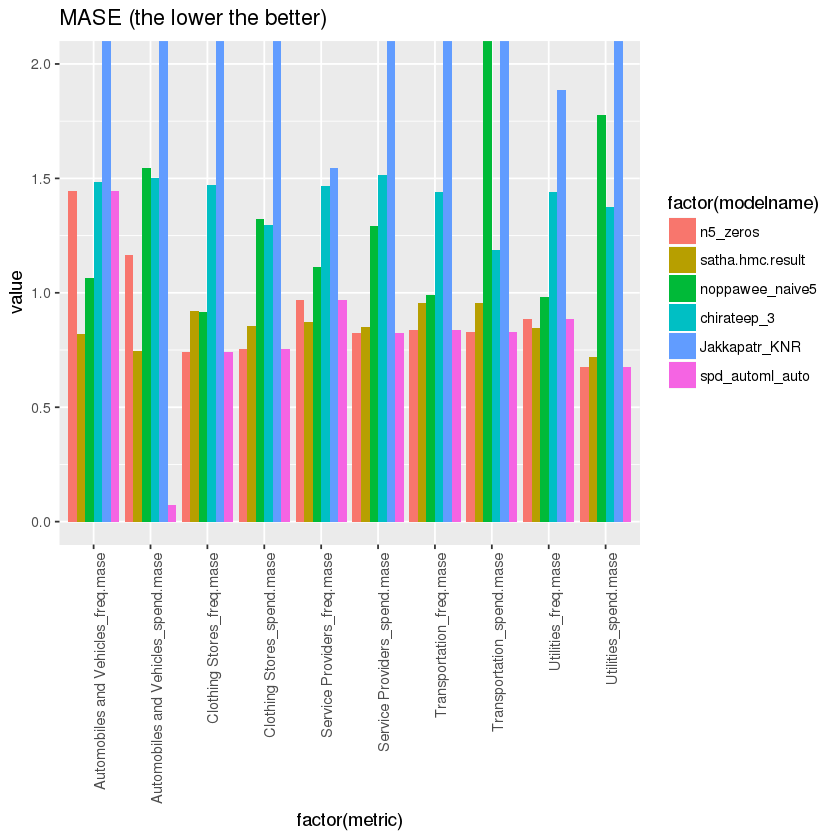

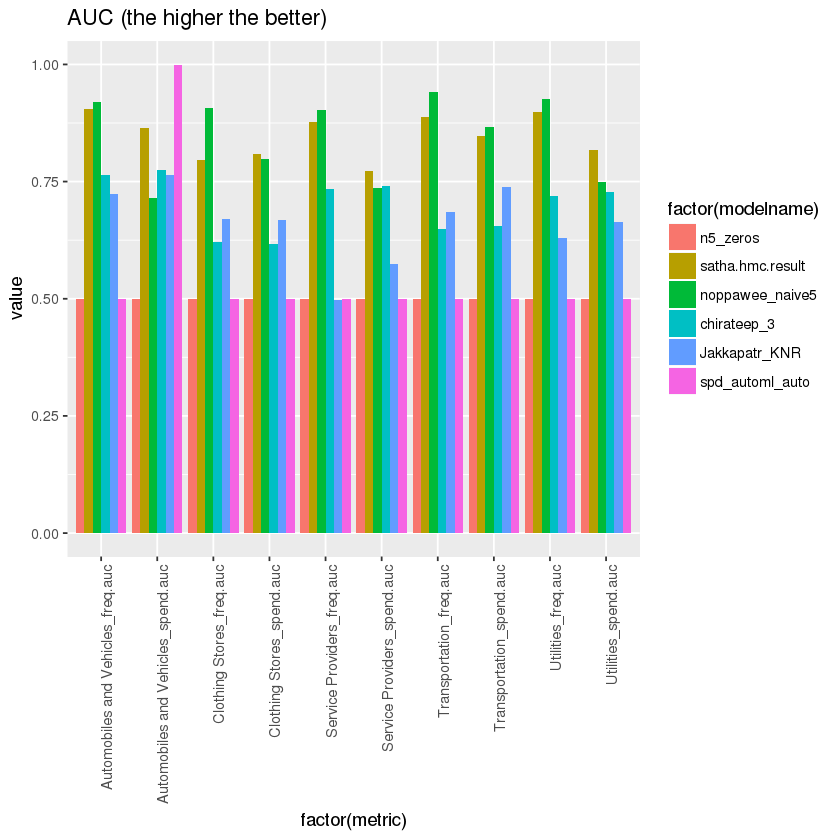

In [44]:
perf_gath_rmse <- gather(perf, metric, value, `Automobiles and Vehicles_freq.rmse`:`Utilities_spend.rmse`)
perf_gath_mae <- gather(perf, metric, value, `Automobiles and Vehicles_freq.mae`:`Utilities_spend.mae`)
perf_gath_mase <- gather(perf, metric, value, `Automobiles and Vehicles_freq.mase`:`Utilities_spend.mase`)
perf_gath_auc <- gather(perf, metric, value, `Automobiles and Vehicles_freq.auc`:`Utilities_spend.auc`)
#ggplot(perf_gath_rmse, aes(x= factor(metric), y=value, fill=factor(modelname)))+
#geom_bar(stat="identity", position="dodge")+ theme(axis.text.x = element_text(angle = 90, hjust = 1))+
#ggtitle("RMSE")
#ggplot(perf_gath_mae, aes(x= factor(metric), y=value, fill=factor(modelname)))+
#geom_bar(stat="identity", position="dodge")+ theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
#ggtitle("MAE")
ggplot(perf_gath_mase, aes(x= factor(metric), y=value, fill=factor(modelname)))+
geom_bar(stat="identity", position="dodge")+ theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
ggtitle("MASE (the lower the better)") + coord_cartesian(ylim = c(0, 2)) 
ggplot(perf_gath_auc, aes(x= factor(metric), y=value, fill=factor(modelname)))+
geom_bar(stat="identity", position="dodge")+ theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
ggtitle("AUC (the higher the better)")
